<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_Proyecto_DFO_NO_RUIDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt


In [152]:
def BFGS(s_k,y_k,g_k,H_k):
    n=len(s_k)
    I=np.identity(n)
    rho=1/max(np.dot(s_k,y_k),10**(-8))
    M_1=np.outer(s_k,y_k)
    M_2=np.outer(y_k,s_k)
    H_k_m=np.dot((I-rho*M_1),np.dot(H_k,(I-rho*M_2)))+rho*np.outer(s_k,s_k)
    return H_k_m
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.dot(Y[-1],Y[-1])))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append((1/max(10**(-6),np.dot(S[m-1-i],Y[m-1-i])))*np.dot(S[m-1-i],q))
        q=q-alphas[i]*Y[m-1-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/max(10**(-6),np.dot(Y[i],Y[i])))*np.dot(Y[i],r)
        r=r+S[i]*(alphas[m-1-i]-beta)#aproximacion de -H*g
    return r

In [129]:
def Rosembrok(X):#X es un vector.
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2))#+10**(-3)*np.random.uniform(0,1))#Ruido
def Rosembrok_grad(X):
    return scipy.optimize.approx_fprime(f=Rosembrok,xk=X,epsilon=10**(-4))
def Rosembrok_Hessian(X):
    M=[]
    #Renglon 1
    D=np.zeros(len(X))
    D[0]=(-400*(X[1]-X[0]**2)+800*(X[0]**2)+2)
    D[1]=-400*(X[1])
    M.append(D)
    #Renglon 2<i<n
    for i in range(1,len(X)-1):
        D=np.zeros(len(X))
        D[i]=(-400*(X[i+1]-X[i]**2)+800*(X[i]**2)+202)
        D[i-1]=-400*X[i-1]
        D[i+1]=-400*X[i]
        M.append(D)
    #Renglon n
    D=np.zeros(len(X))
    D[-2]=-400*X[-2]
    D[-1]=200
    M.append(D)
    return M

In [95]:
def relaxed_Wolfe(x_k,f,fprime,d,e_f,c_1=0.001,c_2=0.9,max_iter=10**4):##Intenté usar scipy.line_search(), pero Strong Wolfe son dificiles de satisfacerse
    #Metodo visto en clase.
    iter=0
    alpha_0=1
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*np.dot(grad_f_k,d)+2*e_f):#Aqui esta la condicion relajada, dado e_f estimacion del error estandar.
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*np.dot(grad_f_k,d)):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i=2*alpha
                else:
                    0.5*(alpha+beta)
            else:
                break
    if(i==max_iter):
        print("F")
    return alpha_i

In [158]:
def ros_chiquito(f,x_0,tol_g=10**(-4),max_iter=10**2):
    #----------------------
    #Listas
    iter=0
    GG=[]
    Y=[]
    S=[]
    #----------------------
    #----------------------
    g_0=Rosembrok_grad(x_0)#Gradiente REAL
    alpha_k=scipy.optimize.line_search(f=f,myfprime=Rosembrok_grad,xk=x_0,pk=-g_0)[0]#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=Rosembrok_grad(x_1)
    #----------------------
    y_k=(g_1-g_0)#diferencia de gradientes
    s_k=-alpha_k*g_0#diferencia de x's
    Y.append(y_k)
    S.append(s_k)
    d_k_r=-np.dot(np.linalg.inv(Rosembrok_Hessian(x_0)),g_0)#Direccion de Newton REAL
    #comp=[np.linalg.norm(d_k_r+g_0)]#Lista para compararlos
    H_k=(np.dot(s_k,y_k)/(np.dot(y_k,y_k)))*np.identity(n)#Dado en clase.
    #----------------------
    while(np.linalg.norm(g_1)>tol_g and iter<max_iter):
        x_0=x_1
        g_0=g_1
        #H_k_m=BFGS(s_k=s_k,y_k=y_k,g_k=0,H_k=H_k)
        #d_k_r=-np.dot(np.linalg.inv(Rosembrok_Hessian(x_0)),g_0)
        d_k_l=-L_BFGS(S=S,Y=Y,g=g_1)
        #d_k=-np.dot(H_k_m,g_0)
        alpha_k_try=scipy.optimize.line_search(f=f,myfprime=Rosembrok_grad,xk=x_0,pk=d_k_l,)[0] #line_search
        if(alpha_k_try!=None):
            alpha_k=alpha_k_try
        x_1=x_0+alpha_k*d_k_l#
        g_1=Rosembrok_grad(x_1)
        iter+=1
        #H_k=H_k_m
        y_k=(g_1-g_0)#diferencia de gradientes
        s_k=alpha_k*d_k_l#diferencia de x's
        Y.append(y_k)
        S.append(s_k)
        #print(np.linalg.norm(d_k-d_k_l))

        GG.append(np.linalg.norm(g_1))
    print("norm:",GG[-1])
    #print("comp:",comp[-1])
    plt.plot(GG)
    plt.show()
    return x_1

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


norm: 5.03255850761624e-05


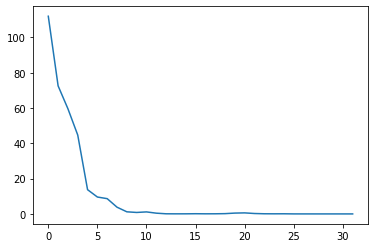

array([0.99985073, 0.99980094, 0.99977588, 0.9997629 , 0.99975547,
       0.9997498 , 0.99974309, 0.99973196, 0.99971076, 0.99966887,
       0.99958505, 0.99941709, 0.99908028, 0.99840499, 0.99705163,
       0.99434214, 0.98892839, 0.97815507, 0.95688911, 0.91558669])

In [160]:
n=20
x_0=np.random.uniform(.7,1.3,size=n)
ros_chiquito(f=Rosembrok,x_0=x_0,tol_g=10**(-4),max_iter=100)